## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
total_rows = df.shape[0]
total_rows

294478

c. The number of unique users in the dataset.

In [4]:
unique_users = df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [5]:
converted_proportion = df.converted.mean()
converted_proportion

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

EXPLANATION: what he means is that, in the test, the control group should always receive the old page, while the treatment group should always receive the new page. 

However, it appears that some of the control group have received the new page, and some of the treatment group have received the old page.

So, we need to get the total number of entries where the treatment group hasn't received the correct page (new page).

In [6]:
control_misaligned = df.query('group == "control" and landing_page != "old_page"')
treatment_misaligned = df.query('group == "treatment" and landing_page != "new_page"')
total_misaligned = control_misaligned.shape[0] + treatment_misaligned.shape[0]
total_misaligned

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# Number of missing values
df.shape[0] - df.dropna().shape[0]

0

**No, none of the rows have missing values**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

**Our decision: Remove these rows. we should only use the rows that we can feel confident in the accuracy of the data.**

a. Store our new dataframe in **df2**.

In [9]:
df2 = df.drop(control_misaligned.index).drop(treatment_misaligned.index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# total number of rows
df2.shape[0]

290585

a. How many unique **user_id**s are in **df2**?

In [13]:
unique_users = df2.user_id.nunique()
unique_users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
# Number of repeated users
df2.shape[0] - unique_users

1

In [15]:
# repeated row
df2[df2.duplicated(subset='user_id', keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# The repeated user ID
df2[df2.duplicated(subset='user_id', keep='first')].user_id.iloc[0]

773192

c. What is the row information for the repeat **user_id**? 

In [17]:
# repeated row
df2[df2.duplicated(subset='user_id', keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

Since, there is consistency with this id, we can probably just choose either and remove. We shouldn't be counting the same user more than once.

In [18]:
df2 = df2.drop_duplicates(subset = 'user_id', keep = 'first')
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

In [19]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
p_converting = df2.converted.mean()
p_converting

0.11959708724499628

**There is 11.95% chance that an individual convert regardless of the page that they receive**

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
p_converted_control = df2.query('group == "control"').converted.mean()
p_converted_control

0.1203863045004612

**There is 12.03% chance that an individual convert if they received the old page**

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
p_converted_treatment = df2.query('group == "treatment"').converted.mean()
p_converted_treatment

0.11880806551510564

**There is 11.88% chance that an individual convert if they received the new page**

d. What is the probability that an individual received the new page?

In [23]:
p_new_page = df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
p_new_page

0.5000619442226688

**There is a little bit more than 50% chance that an individual received the new page, which means that both groups had a fair chance of receiving either of the pages**

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**We don't have sufficient evidence to say that the new treatment page leads to more conversions; because the probability that an individual convert Given that they were in the treatment group is less than the probability that they convert Given that they were in the control group**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**step 1: setup the null hypothesis; which is the belief that we want to test and reject**

**The null hypothesis generally assumes that there's a normality**

**Since we can't actually prove that the new page is better than the old page, we have to find an evidence against the idea that the new page convert rate is worse than or equal to the old page convert rate**

* **The Null H0: New page convert rate is worse than or equal to the old page convert rate**  
p_new_convert_rate - p_old_convert_rate <= 0

**step 2: Define the alternative hypothesis**  
After conducting the A/B test, if we have enough evidence to reject the null hypothesis, we will accept the alternative hypothesis:  

* **The Alternative H1: New page is better than the old page**  
p_new_convert_rate - p_old_convert_rate > 0

**step 3: Choose the significance level**  
Most of the time, researchers choose 0.05; that means the confidence level 95% --> alpha = 0.05; which is the Type I error rate mentioned above

**A p-value with a significance level of less than or equal to 5% means that there is a probability of greater than or equal to 95% that the results are not random. So, our results are significant and there is enough evidence to reject the null hypothesis.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

That means that:   
H0:p = p_old = p_converting = 0.11959708724499628  
and  
H1:p = p_new = p_converting = 0.11959708724499628  

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [24]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [27]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [28]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

this one was tricky. But here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

**step 4: check the standard assumptions for the hypothesis test. There are two assumptions:**  
* We need a simple random sample that represent our popualtion.
* we need a large enough sample size to ensure the distribution of sample proportions are normal

**How to know if the sample is large enough?**  
nXp needs to be at least 10 **and** nX(1-p) also needs to be at least 10

Where:  
**p is our null hypothesis**  
**n is the sample size**

In [29]:
# check 1:
p_new * n_new > 10

True

In [30]:
# check 2:
p_old * n_old > 10

True

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [1 - p_new, p_new])
new_page_converted.mean()

0.12033583373477393

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old, p_old])
old_page_converted.mean()

0.12013849690928866

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.00019733682548526976

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [34]:
p_diffs = []
for _ in range(10000):
    new_page_converted_bootsamp = np.random.choice([0, 1], size = n_new, p = [1 - p_new, p_new])
    old_page_converted_bootsamp = np.random.choice([0, 1], size = n_old, p = [1 - p_old, p_old])
    p_diffs.append(new_page_converted_bootsamp.mean() - old_page_converted_bootsamp.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

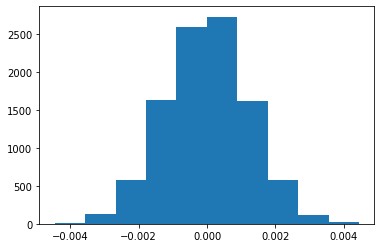

In [35]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
p_diffs = np.array(p_diffs)

In [37]:
actual_new_page_converted = df2.query('landing_page == "new_page"').converted.mean()
actual_new_page_converted

0.11880806551510564

In [38]:
actual_old_page_converted = df2.query('landing_page == "old_page"').converted.mean()
actual_old_page_converted

0.1203863045004612

In [39]:
actual_obs_diff = actual_new_page_converted - actual_old_page_converted
actual_obs_diff

-0.0015782389853555567

We can find the p-value like this:

In [40]:
(p_diffs > actual_obs_diff).mean()

0.9038

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Based on the p-value, we reject or fail to reject a null hypothesis** 

**The smaller the p-value, the stronger the evidence that the null hypothesis (p_new - p_old <= 0) should be rejected.** 

**Since the p-value (0.8998) is higher than the significance level (0.05), we don't have enough evidence to reject the null hypothesis; which means we don't have enough evidence to reject the idea that the new page converting rate is worse than or equal to the old page converting rate; thus, we should keep the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [42]:
from statsmodels.stats.proportion import proportions_ztest

successes = np.array([convert_old, convert_new])
samples = np.array([n_old, n_new])
stat , p_value = proportions_ztest(count = successes, nobs = samples,  alternative = 'smaller')
stat, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is similar to that in the previous question and tells us that we don't have enough evidence to reject the null**

**The stat or test statistic Z means that the observed sample proportion is 1.3 null standard errors above the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**A Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
pd.get_dummies(df2['group']).head()

,control,treatment
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [44]:
# create the ab_page column; and since what we want is 1 when an individual receives the treatment and 0 if control
# we should keep the treatment column and rename it to 'ab_page', and drop the control 
# create the dummy variables
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [45]:
# add intercept column
df2['intercept'] = 1

df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [46]:
# import the model
import statsmodels.api as sm;

# Instantiate the model
X = df2[['ab_page', 'intercept']]
Y = df2['converted']
logistic_model = sm.Logit(Y, X)

# Fit the model
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        16:29:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

In [48]:
p_values = results.pvalues
p_values

ab_page      0.189886
intercept    0.000000
dtype: float64

**p-value associated with ab_page = 0.190**

**The null is that all regression coefficients equal to zero against the alternative that regression coefficients are not zero.**

**Thus, As the p-value of page received (0.19) is higher than the significance level (0.05), we don't have enough evidence to reject the null hypothesis; which means we don't have enough evidence to reject the idea that the regression coeffients of the ab_page is equal to zero; meaning that there is no systematic linear effect of page received on the converting rate.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more terms to the multiple regression inherently improves the fit. It gives a new term for the model to use to fit the data, and a new coefficient that it can vary to force a better fit. Additional terms will always improve the model whether the new term adds significant value to the model or not.** 

**As a matter of fact, adding new variables can actually make the model worse. Adding more and more variables makes it more and more likely that you will overfit your model to the training data. This can result in a model that is making up trends that don’t really exist just to force the model to match the points that do exist.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [49]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [50]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [51]:
pd.get_dummies(df_new.country).head()

,CA,UK,US
user_id,,,
834778,0,1,0
928468,0,0,1
822059,0,1,0
711597,0,1,0
710616,0,1,0


The number of unique values in the country column are 3 variables; thus we need two

In [52]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)
df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


In [53]:
# Instantiate the model
X = df_new[['US', 'UK', 'intercept']]
Y = df_new['converted']
logistic_model = sm.Logit(Y, X)

# Fit the model
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [54]:
# print summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Aug 2021   Pseudo R-squ.:               1.521e-05
Time:                        16:29:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
==============================================================================
"""

**since both p-values are above the significance level of 0.05; we don't have enough evidence to reject the null that is there is no relation between the country and convertion rate**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [55]:
df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


In [56]:
# the interaction between US and the new page
df_new['page_us_inter'] = df_new.ab_page * df_new.US
# the interaction between UK and the new page
df_new['page_uk_inter'] = df_new.ab_page * df_new.UK

df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,page_us_inter,page_uk_inter
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0,0,1


In [57]:
# set the features
X = df_new[['ab_page', 'US', 'UK', 'page_us_inter', 'page_uk_inter', 'intercept']]
# set the prediction column
Y = df_new['converted']
# Instantiate the model
logistic_model = sm.Logit(Y, X)
# Fit the model
results = logistic_model.fit()
# print summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 13 Aug 2021   Pseudo R-squ.:               3.482e-05
Time:                        16:29:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ab_page          -0.0674      0.052     -1.297      0.195      -0.169       0.034
US                0.0175      0.038      0.465      0.642      -0.056       0.091
UK                0.0118      0.040      0.296      0.767      -0.066       0.090
page_us_inter     0.0469      0.054      0.872      0.383      -0.059       0.152
page_uk_inter     0.0783      0.057      1.378      0.168      -0.033       0.190
intercept        -2.0040      0.036    -55.008      0.000      -2.075      -1.933
=================================================================================
"""

**since all p-values are above the significance level of 0.05; we don't have enough evidence to reject the null that is there is no relation between these variables and the convertion rate**

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.